In [108]:
# dataset: healthcare-dataset-stroke-data.csv
# taken from kaggle. 
# url: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset?resource=download&select=healthcare-dataset-stroke-data.csv

# binary classification problem
# given a sety of featurs, determine the probability of stroke.




In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn import metrics
from sklearn.metrics import auc
from tqdm.auto import tqdm

import xgboost as xgb

In [110]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv', header=0)
df.describe()


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [111]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [113]:
df = df.rename(columns={'Residence_type':'residence_type'})

In [114]:
df['work_type'].value_counts()

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

In [115]:
df['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

In [116]:
df['gender'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [117]:
df['heart_disease'].value_counts()

0    4834
1     276
Name: heart_disease, dtype: int64

In [118]:
df['ever_married'].value_counts()

Yes    3353
No     1757
Name: ever_married, dtype: int64

In [119]:
df['smoking_status'].value_counts()

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

In [120]:
#we'll treat 'unknown' as another category of the smk_status, even if it's a non-information bearing category

<AxesSubplot:>

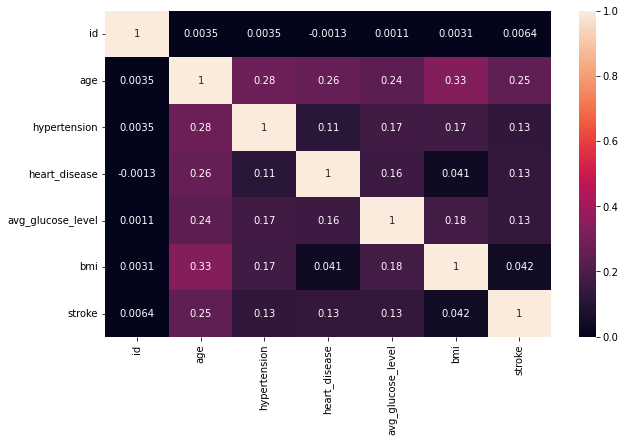

In [121]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.heatmap(df.corr(), ax=ax, annot=True)

In [122]:
#correlation only applies to numeric values. Among these looks like bmi alone seems to have a low correlation with stroke

In [123]:
#let's turn to a way to convert categorical columns to number in order to have a complete correlation matrix.
categorical = ['gender','ever_married','work_type', 'residence_type','smoking_status']

df[categorical]


,gender,ever_married,work_type,residence_type,smoking_status
0,Male,Yes,Private,Urban,formerly smoked
1,Female,Yes,Self-employed,Rural,never smoked
2,Male,Yes,Private,Rural,never smoked
3,Female,Yes,Private,Urban,smokes
4,Female,Yes,Self-employed,Rural,never smoked
...,...,...,...,...,...
5105,Female,Yes,Private,Urban,never smoked
5106,Female,Yes,Self-employed,Urban,never smoked
5107,Female,Yes,Self-employed,Rural,never smoked
5108,Male,Yes,Private,Rural,formerly smoked


In [124]:
df['residence_type']


0       Urban
1       Rural
2       Rural
3       Urban
4       Rural
        ...  
5105    Urban
5106    Urban
5107    Rural
5108    Rural
5109    Urban
Name: residence_type, Length: 5110, dtype: object

In [125]:
from sklearn.preprocessing import LabelEncoder
labenc=LabelEncoder()
gender=labenc.fit_transform(df['gender'])
work_type = labenc.fit_transform(df['work_type'])
ever_married = labenc.fit_transform(df['ever_married'])
residence_type = labenc.fit_transform(df['residence_type'])
smoking_status = labenc.fit_transform(df['smoking_status'])


df['gender'] = gender
df['work_type'] = work_type
df['ever_married'] = ever_married
df['residence_type'] = residence_type
df['smoking_status'] = smoking_status




In [126]:
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67.0,0,1,1,2,1,228.69,36.6,1,1
1,51676,0,61.0,0,0,1,3,0,202.21,NaN,2,1
2,31112,1,80.0,0,1,1,2,0,105.92,32.5,2,1
3,60182,0,49.0,0,0,1,2,1,171.23,34.4,3,1
4,1665,0,79.0,1,0,1,3,0,174.12,24.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,0,80.0,1,0,1,2,1,83.75,NaN,2,0
5106,44873,0,81.0,0,0,1,3,1,125.20,40.0,2,0
5107,19723,0,35.0,0,0,1,3,0,82.99,30.6,2,0
5108,37544,1,51.0,0,0,1,2,0,166.29,25.6,1,0


<AxesSubplot:>

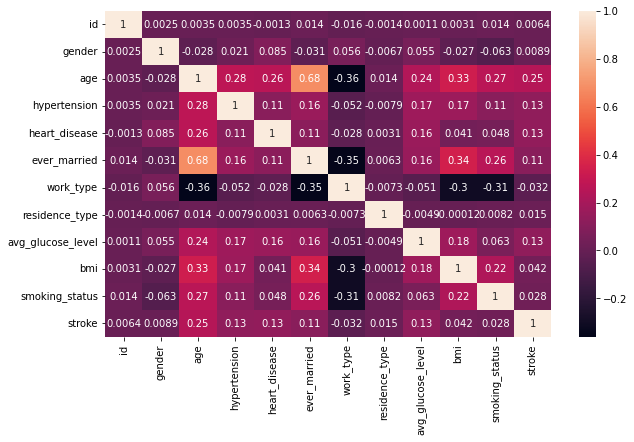

In [127]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.heatmap(df.corr(), ax=ax, annot=True)

In [128]:
df.isnull().sum()


id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

<AxesSubplot:xlabel='bmi', ylabel='Count'>

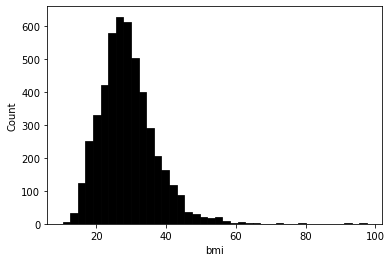

In [129]:
#how is bmi construed / distrbibuted?

%matplotlib inline

plt.figure(figsize=(6, 4))

sns.histplot(df.bmi, bins=40, color='black', alpha=1)

In [130]:
df['bmi'].describe()

count    4909.000000
mean       28.893237
std         7.854067
min        10.300000
25%        23.500000
50%        28.100000
75%        33.100000
max        97.600000
Name: bmi, dtype: float64

In [131]:
df['bmi'].fillna(df['bmi'].mean(),inplace=True)


In [132]:
df.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

<AxesSubplot:xlabel='bmi', ylabel='Count'>

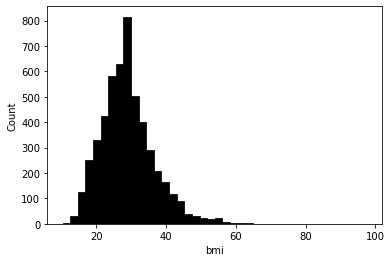

In [133]:

%matplotlib inline

plt.figure(figsize=(6, 4))

sns.histplot(df.bmi, bins=40, color='black', alpha=1)

<AxesSubplot:>

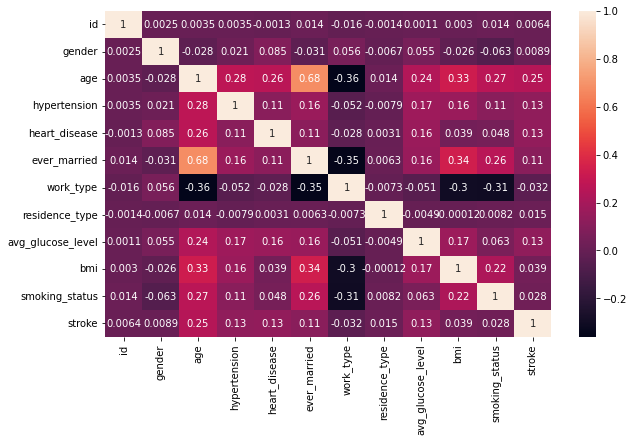

In [134]:
#did the correlation change?
fig, ax = plt.subplots(figsize=(10, 6))

sns.heatmap(df.corr(), ax=ax, annot=True)

In [135]:
#bmi correlation decreased. [after normalizing with the mean]
#highest correlation seems to be age
#lowest (i absolute terms) seems to be gender 

In [136]:
#MODEL TRAINING
df = pd.read_csv('healthcare-dataset-stroke-data.csv', header=0)
df['bmi'].fillna(df['bmi'].mean(),inplace=True)

df = df.drop(columns='id')

y_prep = df.stroke
df_prep = df.drop(columns='stroke')

#build train and validation set with sklearn
# random state for reproducibility of the test.

df_train_full, df_test = train_test_split(df_prep, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=42)

y_train_full, y_test = train_test_split(y_prep, test_size=0.2, random_state=42)
y_train, y_val = train_test_split(y_train_full, test_size=0.25, random_state=42)

import warnings   
warnings.filterwarnings('ignore')


# one hot encoding of the categorical values

train_dict = df_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)

scores = []

# model_1 : logistic regression
# optimization of model_1 on the solver algo and the C variable
# no variation in the penalty choice, so that the default l2 is used for every iteration

for solver_var in tqdm(['newton-cg','lbfgs','liblinear','sag','saga']):
    for c_var in tqdm([0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]):

        model = LogisticRegression(solver=solver_var, C=c_var, max_iter=1000 ,random_state=42)
        model.fit(X_train, y_train)

        val_dict = df_val.to_dict(orient='records')
        X_val = dv.transform(val_dict)

        y_pred = model.predict_proba(X_val)[:, 1]

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

        print('solver=%s C=%s aucvalue: %.3f +- %.3f' % (solver_var, c_var, np.mean(scores), np.std(scores)))
    

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

solver=newton-cg C=0.001 aucvalue: 0.831 +- 0.000
solver=newton-cg C=0.01 aucvalue: 0.831 +- 0.000
solver=newton-cg C=0.1 aucvalue: 0.832 +- 0.001
solver=newton-cg C=1 aucvalue: 0.833 +- 0.001
solver=newton-cg C=10 aucvalue: 0.833 +- 0.002
solver=newton-cg C=100 aucvalue: 0.834 +- 0.002
solver=newton-cg C=1000 aucvalue: 0.834 +- 0.002
solver=newton-cg C=10000 aucvalue: 0.834 +- 0.002


  0%|          | 0/8 [00:00<?, ?it/s]

solver=lbfgs C=0.001 aucvalue: 0.834 +- 0.002
solver=lbfgs C=0.01 aucvalue: 0.833 +- 0.002
solver=lbfgs C=0.1 aucvalue: 0.833 +- 0.002
solver=lbfgs C=1 aucvalue: 0.834 +- 0.002
solver=lbfgs C=10 aucvalue: 0.834 +- 0.002
solver=lbfgs C=100 aucvalue: 0.834 +- 0.002
solver=lbfgs C=1000 aucvalue: 0.834 +- 0.002
solver=lbfgs C=10000 aucvalue: 0.834 +- 0.002


  0%|          | 0/8 [00:00<?, ?it/s]

solver=liblinear C=0.001 aucvalue: 0.823 +- 0.046
solver=liblinear C=0.01 aucvalue: 0.815 +- 0.055
solver=liblinear C=0.1 aucvalue: 0.814 +- 0.054
solver=liblinear C=1 aucvalue: 0.814 +- 0.052
solver=liblinear C=10 aucvalue: 0.815 +- 0.051
solver=liblinear C=100 aucvalue: 0.816 +- 0.050
solver=liblinear C=1000 aucvalue: 0.817 +- 0.049
solver=liblinear C=10000 aucvalue: 0.818 +- 0.048


  0%|          | 0/8 [00:00<?, ?it/s]

solver=sag C=0.001 aucvalue: 0.814 +- 0.052
solver=sag C=0.01 aucvalue: 0.810 +- 0.054
solver=sag C=0.1 aucvalue: 0.808 +- 0.054
solver=sag C=1 aucvalue: 0.807 +- 0.053
solver=sag C=10 aucvalue: 0.806 +- 0.053
solver=sag C=100 aucvalue: 0.805 +- 0.052
solver=sag C=1000 aucvalue: 0.804 +- 0.052
solver=sag C=10000 aucvalue: 0.803 +- 0.051


  0%|          | 0/8 [00:00<?, ?it/s]

solver=saga C=0.001 aucvalue: 0.799 +- 0.055
solver=saga C=0.01 aucvalue: 0.796 +- 0.057
solver=saga C=0.1 aucvalue: 0.794 +- 0.057
solver=saga C=1 aucvalue: 0.792 +- 0.058
solver=saga C=10 aucvalue: 0.790 +- 0.058
solver=saga C=100 aucvalue: 0.788 +- 0.058
solver=saga C=1000 aucvalue: 0.787 +- 0.058
solver=saga C=10000 aucvalue: 0.785 +- 0.058


In [137]:
# best combination of solver and C factor for logistic regression:
# solver=lbfgs C=1 aucvalue: 0.834 +- 0.002


In [138]:



from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)
print(export_text(dt, feature_names=dv.get_feature_names()))


|--- age <= 67.50
|   |--- value: [0.02]
|--- age >  67.50
|   |--- value: [0.17]



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

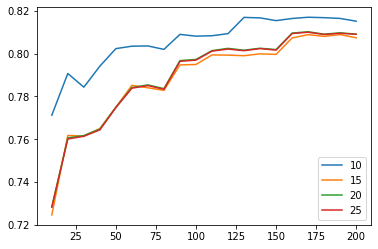

In [139]:
# this is just to confirm that the correlation matrix we found has some solid confirmation in this.
# the DTregressor finds as a first discriminating feature the age, which had the maximum correlation in the corr matrix.

# model_2 : Random forest
# optimization of model_2 on the number of estimators, min leaf, and 

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

scores = []
scores_auc = []

#cicla tra le varie depth dell'albero:

for d in tqdm([10, 15, 20, 25]):
    rf = RandomForestRegressor(n_estimators=0,
                               max_depth=d,
                               random_state=1, 
                               n_jobs=-1)
#per ogni depth, cicla tra tutti i numero estimatori
    for n in tqdm(range(10, 201, 10)):
        rf.n_estimators = n
        rf.fit(X_train, y_train)
#calcola l'errore per la combo depth/estimatori e la appende
        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))
        score_auc = roc_auc_score(y_val, y_pred)
        scores.append((d, n, score))
        scores_auc.append((d, n, score_auc))

        
columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)
#a fine ciclo crea il dataframe (utile per la visualizzazione)

columns2 = ['max_depth', 'n_estimators', 'auc']
df_scores2 = pd.DataFrame(scores_auc, columns=columns2)
#a fine ciclo crea il dataframe (utile per la visualizzazione)


# crea grafico. colori diversi per depth diverse.
#for d in [10, 15, 20, 25]:
#    df_subset = df_scores[df_scores.max_depth == d]
#    plt.plot(df_subset.n_estimators, df_subset.rmse, label=d)

#plt.legend()


for d in [10, 15, 20, 25]:
    df_subset = df_scores2[df_scores2.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.auc, label=d)

plt.legend()




In [140]:
df_subset = df_scores2[df_scores2.max_depth == 10]
df_subset


,max_depth,n_estimators,auc
0,10,10,0.771159
1,10,20,0.790656
2,10,30,0.784265
3,10,40,0.794083
4,10,50,0.802287
5,10,60,0.803414
6,10,70,0.803542
7,10,80,0.801926
8,10,90,0.808933
9,10,100,0.808108


In [146]:
#max auc= 0.81695 is reached with max_depth = 10, n_estimators = 170 

#model_3: xgboost
import xgboost as xgb

features = dv.get_feature_names()
#check that the feature names comply with xgb requirements

features


['Residence_type=Rural',
 'Residence_type=Urban',
 'age',
 'avg_glucose_level',
 'bmi',
 'ever_married=No',
 'ever_married=Yes',
 'gender=Female',
 'gender=Male',
 'heart_disease',
 'hypertension',
 'smoking_status=Unknown',
 'smoking_status=formerly smoked',
 'smoking_status=never smoked',
 'smoking_status=smokes',
 'work_type=Govt_job',
 'work_type=Never_worked',
 'work_type=Private',
 'work_type=Self-employed',
 'work_type=children']

In [184]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

watchlist = [(dtrain, 'train'), (dval, 'val')]


scores = {}



In [172]:
%%capture output

xgb_params = {
    'eta': 0.5, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=500,
                  verbose_eval=5, evals=watchlist)




def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

#key = 'eta=%s' % (xgb_params['eta'])
#scores[key] = parse_xgb_output(output)
#key



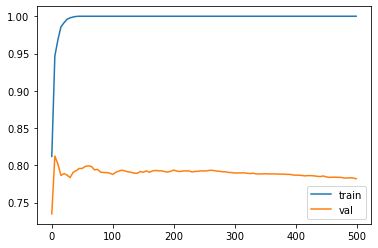

In [173]:
df_score = parse_xgb_output(output)

plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()



In [191]:
%%capture output
#validation shows that xgb stabilizes after 500 iterations. 
#let's try to tune the depth.

#variable max depth: [1, 2, 4, 8, 10, 15, 20]

xgb_params = {
    'eta': 0.3, 
    'max_depth': 20,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    'eval_metric': 'auc',
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=500,
                  verbose_eval=5, evals=watchlist)

scores['depth=20'] = parse_xgb_output(output)


In [192]:
scores

{'depth=1':      num_iter  train_auc  val_auc
 0           0    0.73661  0.69962
 1           5    0.81366  0.79365
 2          10    0.83252  0.82152
 3          15    0.84768  0.82685
 4          20    0.85192  0.82999
 ..        ...        ...      ...
 96        480    0.90302  0.82613
 97        485    0.90339  0.82548
 98        490    0.90344  0.82590
 99        495    0.90357  0.82546
 100       499    0.90378  0.82527
 
 [101 rows x 3 columns],
 'depth=2':      num_iter  train_auc  val_auc
 0           0    0.73661  0.69962
 1           5    0.81366  0.79365
 2          10    0.83252  0.82152
 3          15    0.84768  0.82685
 4          20    0.85192  0.82999
 ..        ...        ...      ...
 96        480    0.90302  0.82613
 97        485    0.90339  0.82548
 98        490    0.90344  0.82590
 99        495    0.90357  0.82546
 100       499    0.90378  0.82527
 
 [101 rows x 3 columns],
 'depth=4':      num_iter  train_auc  val_auc
 0           0    0.78776  0.74100
 1 

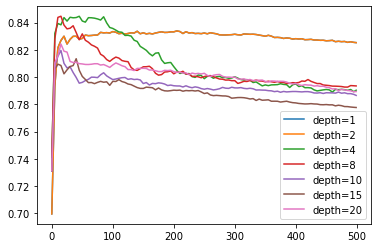

In [194]:


for depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=depth)

plt.legend()



In [220]:
pd.options.display.max_seq_items = 200
pd.set_option('display.max_rows', 1000)
scores['depth=4']



,num_iter,train_auc,val_auc
0,0,0.78776,0.74100
1,5,0.84961,0.83208
2,10,0.85618,0.83932
3,15,0.86269,0.83833
4,20,0.87389,0.84364
5,25,0.88524,0.84105
6,30,0.89276,0.84387
7,35,0.89581,0.84348
8,40,0.90365,0.84366
9,45,0.90709,0.84460


In [221]:
#best combo is depth 4, and 45 iterations
#let's find the best eta within this
scores2 = {}

In [229]:
%%capture output
#validation shows that xgb stabilizes after 500 iterations. 
#let's try to tune the eta.

#variable eta: [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]

xgb_params = {
    'eta': 1, 
    'max_depth': 4,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    'eval_metric': 'auc',
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=500,
                  verbose_eval=5, evals=watchlist)

scores2['eta=1'] = parse_xgb_output(output)

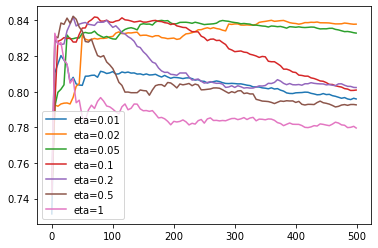

In [231]:
for eta, df_score in scores2.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=eta)

plt.legend()


In [234]:
#at 45 iterations, the best eta is 0.2 auc = .83792
scores2

{'eta=0.01':      num_iter  train_auc  val_auc
 0           0    0.81636  0.73139
 1           5    0.94577  0.81052
 2          10    0.98158  0.81566
 3          15    0.99479  0.82027
 4          20    0.99779  0.81772
 5          25    0.99969  0.81511
 6          30    0.99998  0.80542
 7          35    1.00000  0.80807
 8          40    1.00000  0.80435
 9          45    1.00000  0.80375
 10         50    1.00000  0.80356
 11         55    1.00000  0.80868
 12         60    1.00000  0.80875
 13         65    1.00000  0.80917
 14         70    1.00000  0.80928
 15         75    1.00000  0.80810
 16         80    1.00000  0.81144
 17         85    1.00000  0.81102
 18         90    1.00000  0.81021
 19         95    1.00000  0.81056
 20        100    1.00000  0.81128
 21        105    1.00000  0.80986
 22        110    1.00000  0.81003
 23        115    1.00000  0.81107
 24        120    1.00000  0.81065
 25        125    1.00000  0.81102
 26        130    1.00000  0.81044
 27     

In [ ]:
#final AUC confrontation:
#Logistic regression: 0.834

#RandomForest 0.81695

#XGBoost 0.83792


#the best model is XGBoost
#tuned with:
# iterations = 45
# eta = 0.2
# max_depth = 4
